### Quantum Watermarking - greyscale

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from qiskit import *

In [2]:
C_Image = np.zeros([2,2,3]) # (x,y,RGB)

C_Image[0,0,:] = (0,   128, 128)
C_Image[0,1,:] = (128, 0,   128)
C_Image[1,0,:] = (128, 128, 0)
C_Image[1,1,:] = (128, 128, 128)

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

C_Image = rgb2gray(C_Image)
C_Image

array([[ 89.728 ,  52.8512],
       [113.3952, 127.9872]])

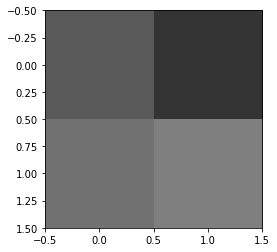

In [5]:
plt.imshow(C_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [6]:
W_Image = np.zeros([2,2,3]) # (x,y,RGB)

W_Image[0,0,:] = (34,   65, 232)
W_Image[0,1,:] = (255, 255,   255)
W_Image[1,0,:] = (228, 128, 54)
W_Image[1,1,:] = (54, 54, 54)

W_Image = rgb2gray(W_Image)
W_Image

array([[ 74.7656, 254.9745],
       [149.4412,  53.9946]])

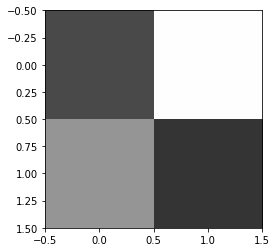

In [7]:
plt.imshow(W_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [151]:
def get_Coeff(Image, watermark=None):
    """ Function that takes in an RGB image matrix of any size and shape and returns qubit coefficients"""
    
    ## build in check sizes Image and watermark are the same
    Flatten_Image = np.reshape(Image, np.shape(Image)[0]*np.shape(Image)[1])
    Theta = Flatten_Image*np.pi/256
    
    if watermark is None:
        Phi = np.zeros(len(Theta))
    else:  
        Flatten_watermark = np.reshape(watermark, np.shape(watermark)[0]*np.shape(watermark)[1])
        Phi = Flatten_watermark*2*np.pi/256

    N = np.ceil(np.log2(np.shape(Image)[0]*np.shape(Image)[1]))/2
    return Phi,Theta,1/(2**N)*np.ndarray.flatten(np.transpose(np.stack((np.cos(Theta/2),np.exp(1j*Phi)*np.sin(Theta/2)))))

In [124]:
State_vector = get_Coeff(C_Image, W_Image)[1]
State_vector

array([ 0.42611477+0.j        , -0.06831626+0.25250563j,
        0.47393845+0.j        ,  0.1592679 -0.00400955j,
        0.38377563+0.j        , -0.27713054-0.16098115j,
        0.35358116+0.j        ,  0.08594517+0.34291951j])

In [104]:
def initialise_state(desired_initial_state):
    n = int(round(np.log2(desired_initial_state.size)))
    
    # if 2**n != desired_initial_state.size:
        # don't run
    
    qc_init = QuantumCircuit(n)

    qc_init.initialize(desired_initial_state, range(n))
    return qc_init

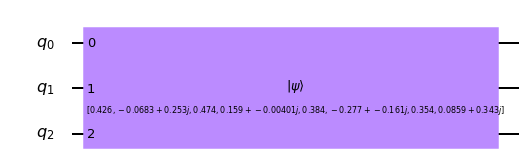

In [105]:
qc_init = initialise_state(State_vector)
qc_init.draw('mpl')

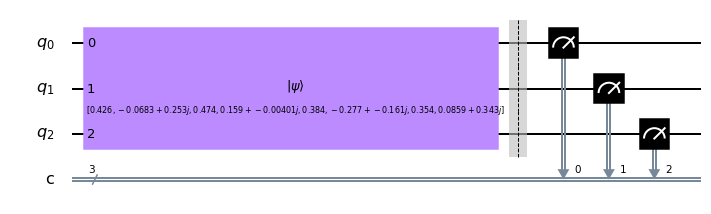

In [106]:
n = int(round(np.log2(State_vector.size)))
shots0 = 100000

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
qc.draw('mpl')

In [107]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'000': 18041, '001': 6775, '010': 22372, '011': 2547, '100': 14856, '101': 10377, '110': 12534, '111': 12498}


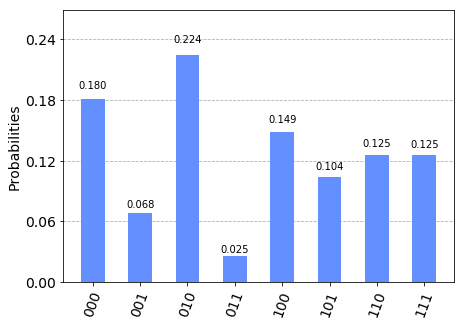

In [108]:
counts = result_sim.get_counts(qc)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [109]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.18041 0.06775 0.22372 0.02547 0.14856 0.10377 0.12534 0.12498]


In [110]:
p0 = probability_vector[0::2]
p1 = probability_vector[1::2]

In [161]:
def get_RGB(P0):
    """ Function that takes the probablity distribution for the colour qubit 0 """
    Theta = 2*np.arccos(np.sqrt(len(P0)*P0))

    return Theta, np.reshape(Theta/np.pi*256,[np.int(np.sqrt(len(Theta))),np.int(np.sqrt(len(Theta)))])

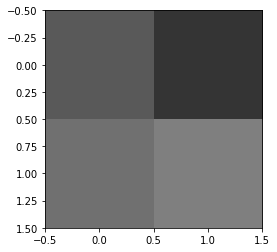

In [162]:
P_Image = get_RGB(p0)[1]
plt.imshow(P_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

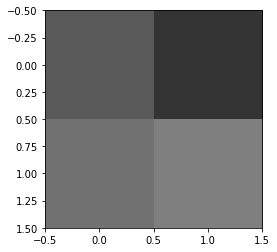

In [113]:
plt.imshow(C_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

### Extracting the watermark

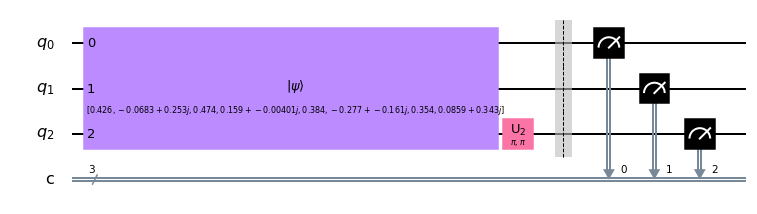

In [138]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas_phi = QuantumCircuit(n, n)
meas_phi.barrier(range(n))
meas_phi.u2(np.pi, np.pi, n-1)
# map the quantum measurement to the classical bits
meas_phi.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc_phi = qc_init + meas_phi

#drawing the circuit
qc_phi.draw('mpl')

In [139]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc_phi, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'000': 327993, '001': 63645, '010': 342640, '011': 87830, '100': 958, '101': 107137, '110': 7124, '111': 62673}


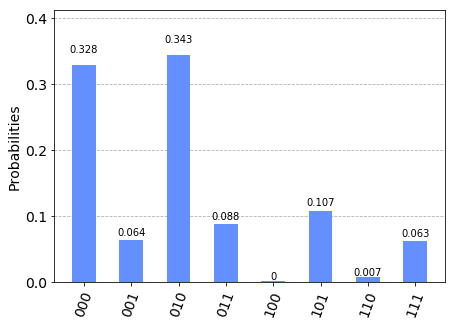

In [140]:
counts = result_sim.get_counts(qc_phi)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [141]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.327993 0.063645 0.34264  0.08783  0.000958 0.107137 0.007124 0.062673]


In [142]:
P0_1 = probability_vector[0::2] 
P1_1= probability_vector[1::2]

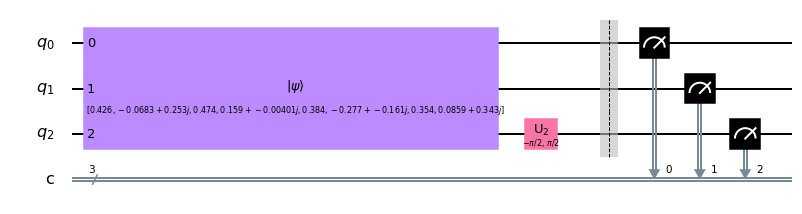

In [143]:
n = int(round(np.log2(State_vector.size)))
shots0 = 1000000

# Create a Quantum Circuit
meas_phi2 = QuantumCircuit(n, n)
meas_phi2.barrier(range(n))
meas_phi2.u2(-np.pi/2, np.pi/2, n-1)
# map the quantum measurement to the classical bits
meas_phi2.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc_phi2 = qc_init + meas_phi2

#drawing the circuit
qc_phi2.draw('mpl')

In [144]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc_phi2, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'000': 164374, '001': 166430, '010': 175052, '011': 129981, '100': 164335, '101': 4570, '110': 174781, '111': 20477}


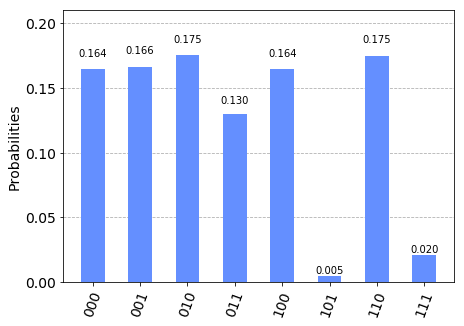

In [145]:
counts = result_sim.get_counts(qc_phi2)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [146]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.164374 0.16643  0.175052 0.129981 0.164335 0.00457  0.174781 0.020477]


In [147]:
P0_2 = probability_vector[0::2] 
P1_2 = probability_vector[1::2]

In [148]:
x = P0_1 - P1_1
y = P0_2 - P1_2

In [149]:
def get_watermark(x,y):
    """ Returns RGB watermark matrix image from the probabilities of the colour qubit being 0 (P0) or 1 P(1)
        and the carrier image is encoded by the angles Theta.
    """
    Phi = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] > 0 and y[i] > 0:
            Phi[i] = np.arctan(y[i]/x[i])
        elif x[i] > 0 and y[i] < 0:
            Phi[i] = 2*np.pi + np.arctan(y[i]/x[i])
        elif x[i] < 0:
            Phi[i] = np.pi + np.arctan(y[i]/x[i])
            

    return Phi, np.reshape(Phi/2/np.pi*256,[np.int(np.sqrt(len(Phi))),np.int(np.sqrt(len(Phi)))])

In [150]:
get_watermark(x,y)

(array([6.27540784, 0.17507001, 2.15736324, 1.91634938]),
 array([[255.68311738,   7.13299378],
        [ 87.89888608,  78.07909811]]))

In [202]:
W_Image

array([[ 74.7656, 254.9745],
       [149.4412,  53.9946]])

In [1]:
x_check = np.cos(get_Coeff(C_Image, W_Image)[0])*np.sin(get_Coeff(C_Image, W_Image)[1])
y_check = np.sin(get_Coeff(C_Image, W_Image)[0])*np.sin(get_Coeff(C_Image, W_Image)[1])

print(x_check)
print(x)

NameError: name 'np' is not defined

### Bigger Image

In [43]:
img_file = os.path.expanduser("IBM-logo.png")

In [96]:
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
res = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)

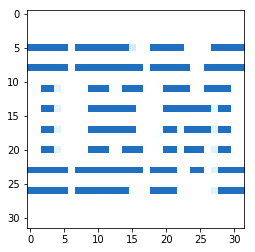

In [97]:
plt.imshow(res)

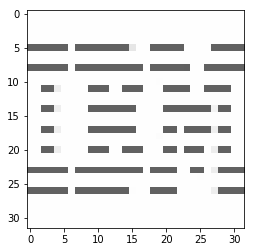

In [130]:
C_Image = rgb2gray(res)
plt.imshow(C_Image/256, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [83]:
State_vector = get_Coeff(C_Image)
State_vector

array([0.01104941+0.j, 0.01104768+0.j, 0.01104941+0.j, ...,
       0.01104768+0.j, 0.01104941+0.j, 0.01104768+0.j])